# Predicting minimum temperatures in Urbana, Illinois

---
embed-resources: true
---

## Introduction

This report is for the Office of the Mayor, to be shared with the full City Council. We are here asked to provide a good estimate of when markets should move indoors when the winter season arrive in 2005.

## Methods

In [27]:
# imports
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

We introduce sklearn functions to help us calculate important numbers such as the Root Mean Squared Error and use the neighboor regressor function.

### Data

In [28]:
# load data
weather_train = pd.read_parquet(
    "https://cs307.org/lab/data/weather-train.parquet",
)
weather_vtrain = pd.read_parquet(
    "https://cs307.org/lab/data/weather-vtrain.parquet",
)
weather_validation = pd.read_parquet(
    "https://cs307.org/lab/data/weather-validation.parquet",
)
weather_test = pd.read_parquet(
    "https://cs307.org/lab/data/weather-test.parquet",
)
weather_train

,temperature_2m_min,year,month,day,day_of_year
date,,,,,
2016-01-01,-4.2715,2016,1,1,1
2016-01-02,-3.8715,2016,1,2,2
2016-01-03,-4.4715,2016,1,3,3
2016-01-04,-3.0215,2016,1,4,4
2016-01-05,-5.7715,2016,1,5,5
...,...,...,...,...,...
2022-12-27,-11.0520,2022,12,27,361
2022-12-28,-5.9020,2022,12,28,362
2022-12-29,5.0980,2022,12,29,363


In [29]:
# summary statistics
year_summ = weather_train.groupby('year')['temperature_2m_min'].agg(['mean', 'std']).reset_index()
year_summ

,year,mean,std
0,2016,8.793390,10.274506
1,2017,8.399644,9.692305
2,2018,7.591013,11.369452
3,2019,7.229781,10.882259
4,2020,7.684612,9.383594
5,2021,8.119370,10.388490
6,2022,7.010192,11.028170


In [30]:
month_summ = weather_train.groupby('month')['temperature_2m_min'].agg(['mean', 'std']).reset_index()
month_summ

,month,mean,std
0,1,-5.416767,6.547430
1,2,-4.380614,6.746121
2,3,1.522173,5.595675
3,4,5.925214,5.659612
4,5,12.639454,5.234890
5,6,18.211405,3.540279
6,7,19.998209,2.627939
7,8,19.088070,2.874603
8,9,16.571642,3.988397
9,10,9.756274,5.775242


In these stats, we see the average and standard deviation of temperatures of every year and also each of the months. 

<Axes: xlabel='year', ylabel='mean'>

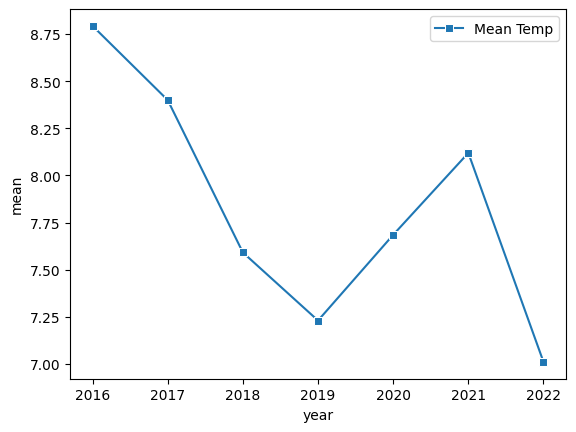

In [31]:
# exploratory visualization
sns.lineplot(data=year_summ, x='year', y='mean', marker='s', label='Mean Temp')


With the graph above, we can see the average temperatures of each year and see how hot or cold a particular a year was and how much it has changed since the previous years.

<Axes: xlabel='month', ylabel='mean'>

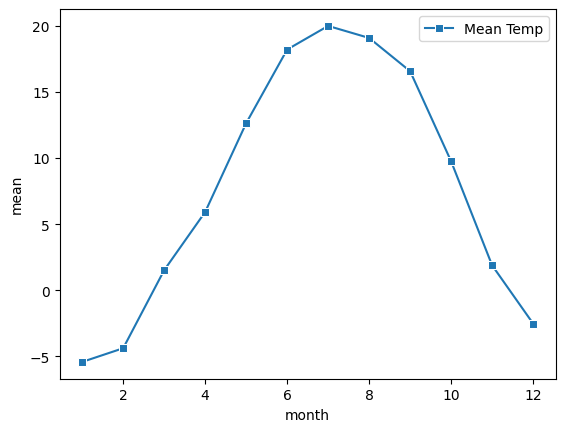

In [32]:
sns.lineplot(data=month_summ, x='month', y='mean', marker='s', label='Mean Temp')

This graph above shows the average temperature of each month. We can see how from months 5-9 are the hottest which makes sense due to the summer and months 1-4 and 10-12 are colder due to the winter seasons.

### Models

In [33]:
# process data for ML
X_train = weather_train[["year", "day_of_year"]]
y_train = weather_train["temperature_2m_min"]

# create X and y for validation-train
X_vtrain = weather_vtrain[["year", "day_of_year"]]
y_vtrain = weather_vtrain["temperature_2m_min"]

# create X and y for validation
X_validation = weather_validation[["year", "day_of_year"]]
y_validation = weather_validation["temperature_2m_min"]

# create X and y for test
X_test = weather_test[["year", "day_of_year"]]
y_test = weather_test["temperature_2m_min"]


We first split the data into train and test data sets and set the test data aside for now. We will focus on spliting the training data once more into validation train data and regular validation data. We will use the validation train sets to fit the model and predict the regualr validation data.

In [34]:
# train models
val_rmse_values = []
k_to_try = [1, 5, 10, 25, 50, 100, 250, 500]
for k in k_to_try:
    knn = KNeighborsRegressor(n_neighbors=k, p=1)  # manhattan distance via minkowski with p=1)
    knn.fit(X_vtrain, y_vtrain)
    pred = knn.predict(X_validation)
    val_rmse = root_mean_squared_error(y_validation, pred)
    val_rmse_values.append(val_rmse)
val_rmse_values


[6.285232067108154,
 5.397881031036377,
 5.098583698272705,
 5.024857044219971,
 4.994802474975586,
 4.974940299987793,
 4.993910789489746,
 5.6319899559021]

Here we can see the RMSE for each of the given k-values for the validation set.

In [35]:
# get best validation k and rmse
knn_k_best = k_to_try[np.argmin(val_rmse_values)]
knn_val_rmse_best = min(val_rmse_values)

# refit to full train data
mod = KNeighborsRegressor(
    n_neighbors=knn_k_best,
    p=1,
)
mod.fit(X_train, y_train)

# calculate test RMSE
pred = mod.predict(X_test)
knn_test_rmse = root_mean_squared_error(y_test, pred)


We have some k-values to try out to see which k value would be best for our model so we make a list of values and make a fucntion where we can see the RMSE of each k-value. After getting the best k-value, we are then able to use that value to use on the regular train data.

## Results

In [36]:
# report model metrics
pred = mod.predict(X_test)
knn_test_rmse = root_mean_squared_error(y_test, pred)
knn_test_rmse


4.725839138031006

The selected model achives a test RMSE of 4.725839138031006

In [37]:
# serialize model
from joblib import dump
dump(knn, "weather.joblib")

['weather.joblib']

## Discussion

Our K Neighbors model gives us a Test RMSE of 4.73 °C when trying to predict the daily minimum temperature. The RMSE value represents the average error is from the actual value. This means that the model's predictions are about 4.73 °C off than of the actual value. So for example, if a day is actually 10°C, the model here would predict that the day would be 14.73 °C or a 5.27 °C day.


When considering of having a threshold of 4°C, this margin of error is too large and can cause many problems. It is possible for the model to have an overestimation. When the actual temperature is lower than the predicted temperature, it will mislead people to stay out longer which can be dangerous for people. The same can go for when the model underestimates the temperature. When the actual temperature is higher than the predicted temperature, this can cause people to move indoors too quickly which will reduce capacity and sales.


Because of the large difference in temperature of the model and the actual temperature, we should not use this model. Even though the model gives a decent estimation of the minimum temperature, we need more than "decent" predictions when it comes to weather and people's businesses and safety. The margin of error is too large and is not accurate enough which can cause people to be in uncomfortable and dangerous situations.


In order to achieve a better RMSE score, it would be better to work with a dataset with more features affecting the temperature. For example, we could add wind speed, humidity levels, Sun SPF, past patterns, etc. Having more features lets us explore how and what affects the temperature giving further accurate predictions.


The graph below shows the predictive ranges of temperatures for each day of the year and the red line represents the threshold of 4°C. We can see some extreme ranges due to our RMSE value being so high which is another sign that we should not use this model. This large range does not give us accurate predictions of the temperature since we can see some ranges being both below and over the redline, especially near the beginning and end of the year.


Overall, we should not use this model because the RMSE value of 4°C is too large of a margin to trust on especially when it risks people's health.



/var/folders/tb/gxmnn8011191kwx1sz61vls40000gq/T/ipykernel_61975/2183422090.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=weather_train, x='day_of_year', y='temperature_2m_min', hue='year', ci="sd")


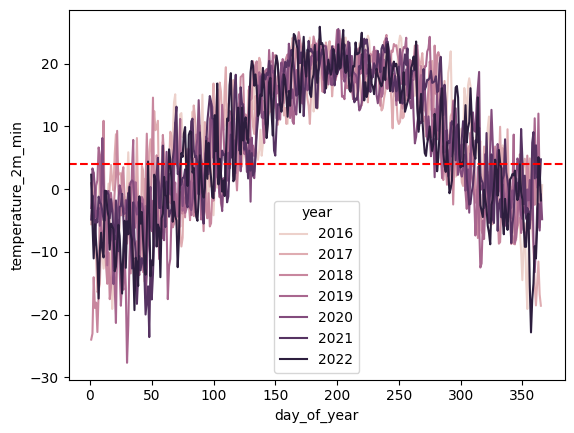

In [38]:
#summary
sns.lineplot(data=weather_train, x='day_of_year', y='temperature_2m_min', hue='year', ci="sd")
plt.axhline(y= 4, color = 'r', linestyle = '--', label = "Threshold, 4 Degrees C")